In [208]:
%matplotlib inline
import shapely
from shapely.ops import split
from shapely.geometry import LineString, Polygon, shape, mapping
import os
import pandas as pd
from matplotlib import pyplot as plt
import fiona
import geopandas as gpd
import sys
from pprint import pprint
from datetime import datetime as dt

In [347]:
basepath = os.path.join('/Users','robwebster','Sync','msc_course','dissertation', 'data', 'new_glacier_fronts')
boxfile = os.path.join(basepath, 'boxes_by_glacier_name', 'lyell.shp')
linesfile = os.path.join(basepath, 'fronts_by_glacier_name', 'lyell.shp')
outpath = os.path.join(basepath, 'box_method_files')

In [326]:
def get_earliest_year(lines):
    #  Loops through a line layer and returns the earliest year
    early = 2030
    for line in lines:
        if line['properties']['year'] < early:
            early = line['properties']['year']
    return early

In [350]:
# Change to True to enable writing results to file.
w = True

new_polygons = []
new_lines = []
avgm_values = []
rel_retreat_values = []
current_year = []

with fiona.open(boxfile) as box:
    boxwidth = box[0]['properties']['width']
    sbox = shape(box[0]['geometry'])
    with fiona.open(linesfile) as lines:
        
        current_glacier = lines[0]['properties']['gl_name']

        print('Processing : ', current_glacier, '\n')
        
        fn = current_glacier.lower().split(' gl')[0].lower()
        out_filepath = os.path.join(outpath, f'{fn}_boxresults.shp')
        
        if w:    
            print(f'Output file will be - {out_filepath}')
        
        # Dummy variable to be updated by search for earliest year
        earliest_year = get_earliest_year(lines)
            
        print("Earliest record for this glacier is from", earliest_year, '\n')
        
        # Update the lines schema to include new attributes, ready for writing out new shapefile
        updated_schema = lines.schema
        updated_schema['properties']['measurement'] = 'int:10'
        updated_schema['properties']['rel_posn'] = 'int:10'
        
        # New outputs will include the same attributes as the lines, but now with polygons assosciated
        # so need to update the geometry type for the new layer to Polygon
        updated_schema['geometry'] = 'Polygon'
        
        # Display details of the schema
        #pprint(updated_schema)
        
        # Open a connection to a new shapefile for writing the outputs
        with fiona.open(out_filepath,'w', driver='ESRI Shapefile', crs=box.crs,schema=updated_schema) as ouput:
            
            print("Box CRS - ", box.crs['init'])
            print("Lines CRS - ", lines.crs['init'], '\n')
            
            if not box.crs == lines.crs:
                print('CRS of input layers do not match!')
                sys.exit()
            
            for line in lines:
                shapely_line = shape(line['geometry'])
                #pprint(line['geometry'])
                year = line['properties']['year']
                
                # This is the line that actually splits the box with the line,
                result = split(sbox, shapely_line)
                
                # Only valid splits will have more than one feature
                if len(result) > 1:
                    
                    # Calculate the average front position measurement by dividing resulting polygon
                    # area by the width of the rectilinear box
                    
                    avgm = result[1].area/boxwidth
                    
                    # Update the attributes to include this new measurement
                    line['properties']['measurement'] = int(avgm)
                    
                    # Set the zero point for relative position calculations
                    if year == earliest_year:
                        zero_position = int(avgm)   
                    
                    # Update the various lists to hold results for this iteration
                    current_year.append(line['properties']['year'])
                    new_polygons.append(result)
                    avgm_values.append(avgm)
                    new_lines.append(line)
                    
                else:
                    print(f'Invalid result for year {year}, continuing...\n')
            
            # Iterate again, this time to add the relative position details by subtracting the average
            # frontal position in the earliest year (zero_position) from each measurement columnn value.
            
            for line, result in zip(new_lines, new_polygons):  
                line['properties']['rel_posn'] = (line['properties']['measurement']) - zero_position
                
                # Toggle This For Troubleshooting New Glaciers
                #pprint(line['properties'])
                
                # Set 'w' flag at the top of the script - if true, the shapefile will be written to disk
                if w:
                    ouput.write({'geometry':mapping(result[1]),'properties': line['properties']})

Processing :  Lyell Glacier 

Output file will be - /Users/robwebster/Sync/msc_course/dissertation/data/new_glacier_fronts/box_method_files/lyell_boxresults.shp
Earliest record for this glacier is from 1993 

Box CRS -  epsg:3762
Lines CRS -  epsg:3762 



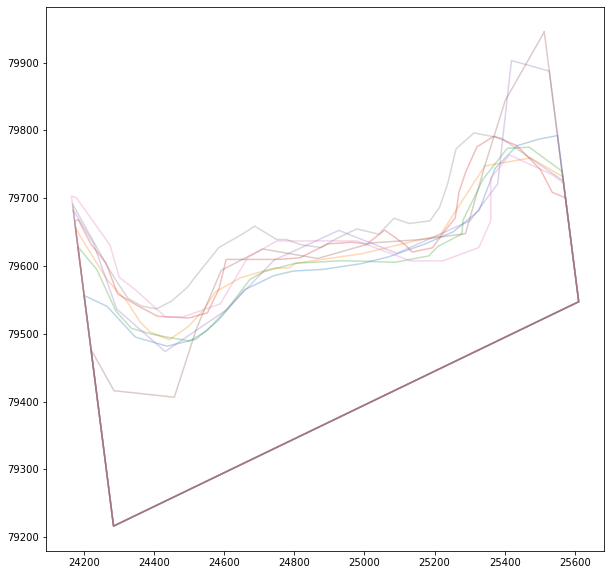

In [343]:
fig, ax = plt.subplots(figsize=(10, 10))

total = zip(new_polygons, current_year)

#ax.plot(*sbox.exterior.xy)
#ax.plot(*shapely_test_line.xy)

for poly, year in total:
    ax.plot(*poly[1].exterior.xy, alpha=0.3)


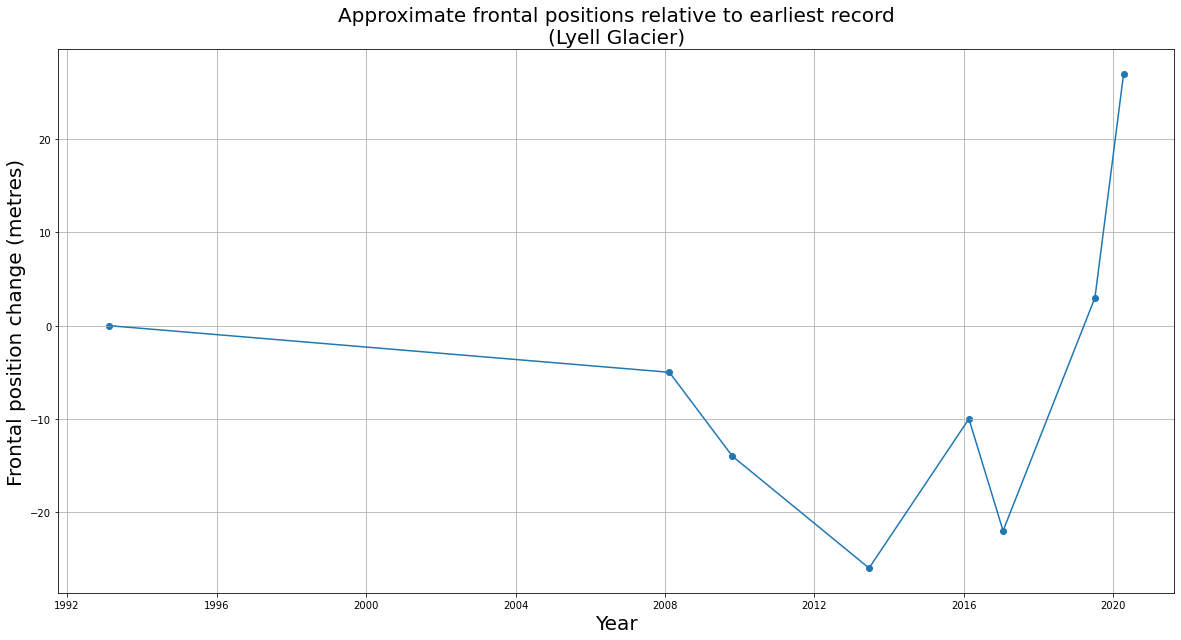

In [344]:
fig, ax = plt.subplots(figsize=(20, 10))

x = []
y = []

for poly, line in zip(new_polygons, new_lines):
    x.append(dt.strptime(line['properties']['date'], '%Y%m%d'))
    y.append(line['properties']['rel_posn'])

glacier = new_lines[0]['properties']['gl_name']
    
    
df = pd.DataFrame(y, x)
df.index = df.index.normalize()
df = df.sort_index()

ax.set_xlabel('Year', fontsize=20)
ax.set_ylabel('Frontal position change (metres)', fontsize=20)
ax.set_title(f'Approximate frontal positions relative to earliest record\n({glacier})', fontsize=20)

ax.grid()

ax.plot(df.loc[:])
ax.scatter(df.index, df.iloc[:,0])